<a href="https://colab.research.google.com/github/H-Elizabeth/capstone-dirty-water-notebook/blob/main/Dirty_Water_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dash pandas plotly geopandas numpy requests gdown --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 23.3 MB/s eta 0:00:00


In [ ]:
import dash
from dash import dcc, html, callback_context
from dash.dependencies import Input, Output, State
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import numpy as np
import bisect
import plotly.colors
import plotly.tools as tools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.gridspec as gridspec
import requests
import os
import gdown
from google.colab import drive, userdata
drive.mount('/content/drive')

def dms_to_dd(dms):
    try:  # Accounting for multiple styles of coordinate entries
        dms = dms.replace(" ", "").replace("°", " ").replace("'", " ").replace('"', " ")
        parts = dms.split()
        dd = float(parts[0]) + float(parts[1])/60 + float(parts[2])/(60*60)
        if len(parts) > 3 and parts[3] in ('S','W'):
            dd *= -1
    except:  # The coordinate is already in DD
        dd = float(dms)
    return dd

# # Read the shapefile data
# gdf = gpd.read_file('sdCreek.shp')

# # Convert the GeoDataFrame to GeoJSON
# geojson = gdf.to_json()

# # Print out columns for testing
# print(gdf.columns)

Mounted at /content/drive


In [ ]:
# aggregated_geom = gdf.unary_union
# fig, ax = plt.subplots()
# gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)
# gpd.GeoSeries([aggregated_geom]).plot(ax=ax, color='red', alpha=0.5)
# plt.show()
# print(aggregated_geom.geom_type)

In [ ]:
# Load the geolabels data
geolabels_link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9KmvTArEvOntjGpzFbpai7tfGCE4atG7cre5BiG_CEhMQw7cOo6bz-SmgJRY7rGCP7ERnRywkwiw7/pub?gid=402113435&single=true&output=csv'
geolabels = pd.read_csv(geolabels_link)
# Original non-live spreadsheet: geolabels = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vShI2wq6ImCjv3I06xzelAPInOzCoz1rpuYJkNS4vcNIniQM-lvmDHabJ_h3aJG3opodc_kQR_SPsbG/pub?gid=402113435&single=true&output=csv')

# Load the samples data
samples_link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9KmvTArEvOntjGpzFbpai7tfGCE4atG7cre5BiG_CEhMQw7cOo6bz-SmgJRY7rGCP7ERnRywkwiw7/pub?gid=1821472518&single=true&output=csv'
samples = pd.read_csv(samples_link)
# Original non-live spreadsheet: samples = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vShI2wq6ImCjv3I06xzelAPInOzCoz1rpuYJkNS4vcNIniQM-lvmDHabJ_h3aJG3opodc_kQR_SPsbG/pub?gid=1821472518&single=true&output=csv')

# Load the encampments data
encampments_link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9KmvTArEvOntjGpzFbpai7tfGCE4atG7cre5BiG_CEhMQw7cOo6bz-SmgJRY7rGCP7ERnRywkwiw7/pub?gid=1918593179&single=true&output=csv'
encampments = pd.read_csv(encampments_link)
# Original non-live spreadsheet: encampments = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vShI2wq6ImCjv3I06xzelAPInOzCoz1rpuYJkNS4vcNIniQM-lvmDHabJ_h3aJG3opodc_kQR_SPsbG/pub?gid=1918593179&single=true&output=csv')

# PRINTING DATATYPES FOR TESTING
print("Data types for geolabels:")
print(geolabels.dtypes)

print("\nData types for samples:")
print(samples.dtypes)

print("\nData types for encampments:")
print(encampments.dtypes)

Data types for geolabels:
Key           object
Latitude     float64
Longitude    float64
Nickname      object
Address       object
dtype: object

Data types for samples:
SampleSite              object
Month                   object
Day                    float64
Year                   float64
TIME                    object
pH                     float64
TEMP                   float64
DO(mg/L)               float64
Conductivity(us/cm)    float64
Phosphorus              object
Ecoli (MPN/100mL)       object
Enterococcus            object
D.O%                   float64
ImageURL                object
dtype: object

Data types for encampments:
EncampmentSite       object
Month                object
Day                   int64
Year                  int64
HomelessnessScore    object
Notes                object
Unnamed: 6           object
Unnamed: 7           object
dtype: object


In [ ]:
# Converts x to numeric so we can use it
encampments['HomelessnessScore'] = encampments['HomelessnessScore'].replace('x', 2)
encampments['HomelessnessScore'] = pd.to_numeric(encampments['HomelessnessScore'])

# Remove the space from the 'SampleSite' values
samples['SampleSite'] = samples['SampleSite'].str.replace(' ', '')

# Convert the coordinates to decimal degrees
geolabels['Latitude'] = geolabels['Latitude'].apply(dms_to_dd)
geolabels['Longitude'] = geolabels['Longitude'].apply(dms_to_dd)

# Merge the samples and geolabels dataframes ie add coordinates to sites
merged = samples.merge(geolabels, left_on='SampleSite', right_on='Key')

# Remove the trailing spaces from the 'Month' values
merged['Month'] = merged['Month'].str.strip()

# Convert month names to numerical values
merged['Month'] = pd.to_datetime(merged['Month'], format='%B').dt.month

# Create a datetime column for the slider
merged['date'] = pd.to_datetime(merged[['Year', 'Month', 'Day']])

# Strip leading and trailing spaces from 'Month' in encampments
encampments['Month'] = encampments['Month'].str.strip()

# Convert month names to numerical values for encampments
encampments['Month'] = pd.to_datetime(encampments['Month'], format='%B').dt.month

# Create a datetime column for the slider for encampments
encampments['date'] = pd.to_datetime(encampments[['Year', 'Month', 'Day']])

# Merge the encampments and geolabels dataframes ie add coordinates to sites
merged_encampments = encampments.merge(geolabels, left_on='EncampmentSite', right_on='Key')

In [ ]:
# print(type(merged_encampments))
# test = gpd.GeoDataFrame(merged_encampments, geometry=gpd.points_from_xy(merged_encampments.Longitude, merged_encampments.Latitude), crs="EPSG:4326"
# )
# # print(merged_encampments[['Unnamed: 6', 'Unnamed: 7']])
# test.plot()
# print(test.crs)

In [ ]:
# List of columns to clean
columns_to_clean = ["pH", "TEMP", "DO(mg/L)", "Conductivity(us/cm)", "Ecoli (MPN/100mL)", "Enterococcus", "D.O%", "Phosphorus"]

# Accounts for 'ND' and '>' in numeric fields
for column in columns_to_clean:
    merged[column].fillna(-1, inplace=True)
    merged[column] = merged[column].astype(str)  # Convert the column to string type
    print('\nRows where', column, 'contains "ND": \n', merged[merged[column].str.contains("ND")][column])
    merged[column] = merged[column].replace(["ND"], "-1")  # Replace "ND" with -1
    print('\n', column, 'contains ">" char: \n', merged[merged[column].str.contains(">")][column])
    merged[column] = merged[column].str.replace(">", "")  # Remove ">" character
    merged[column].fillna("-1")
    merged[column] = pd.to_numeric(merged[column], errors='coerce')  # Convert the cleaned column to numeric

# PRINTING DATATYPES FOR TESTING
print("\nData types for geolabels:")
print(geolabels.dtypes)

print("\nData types for samples:")
print(merged.dtypes)

print("\nData types for encampments:")
print(encampments.dtypes)


print(merged.sort_values(by='date')[['SampleSite','date', 'DO(mg/L)']])

<ipython-input-7-a4123da2ad6b>:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-7-a4123da2ad6b>:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[co


Rows where pH contains "ND": 
 Series([], Name: pH, dtype: object)

 pH contains ">" char: 
 Series([], Name: pH, dtype: object)

Rows where TEMP contains "ND": 
 Series([], Name: TEMP, dtype: object)

 TEMP contains ">" char: 
 Series([], Name: TEMP, dtype: object)

Rows where DO(mg/L) contains "ND": 
 Series([], Name: DO(mg/L), dtype: object)

 DO(mg/L) contains ">" char: 
 Series([], Name: DO(mg/L), dtype: object)

Rows where Conductivity(us/cm) contains "ND": 
 Series([], Name: Conductivity(us/cm), dtype: object)

 Conductivity(us/cm) contains ">" char: 
 Series([], Name: Conductivity(us/cm), dtype: object)

Rows where Ecoli (MPN/100mL) contains "ND": 
 Series([], Name: Ecoli (MPN/100mL), dtype: object)

 Ecoli (MPN/100mL) contains ">" char: 
 152    >2419.6
156    >2419.6
162    >2419.6
163    >2419.6
164    >2419.6
Name: Ecoli (MPN/100mL), dtype: object

Rows where Enterococcus contains "ND": 
 Series([], Name: Enterococcus, dtype: object)

 Enterococcus contains ">" char: 
 142

<ipython-input-7-a4123da2ad6b>:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
# Converts 'date' column to string
merged['date_str'] = merged['date'].dt.strftime('%Y-%m-%d')

# Gets the sorted unique dates for the encampments
unique_dates_encampments = sorted(merged_encampments['date'].unique())
unique_dates = sorted(merged['date'].unique())

# Replace no nickname values in 'Nickname' with 'Unnamed Site'
merged['Nickname'] = merged['Nickname'].fillna(merged['Key'])

print(f"Unique encampment dates: {len(unique_dates_encampments)}")
print(f"Unique sample site dates: {len(unique_dates)}")

Unique encampment dates: 15
Unique sample site dates: 13


In [ ]:
min_date = min(merged['date'].min(), merged_encampments['date'].min())
max_date = max(merged['date'].max(), merged_encampments['date'].max())
date_range = pd.date_range(min_date, max_date)
sample_dates = merged['date'].unique()
encampment_dates = merged_encampments['date'].unique()
unique_dates = [pd.to_datetime(date).date() for date in unique_dates]
# Combine and sort the dates
unique_dates = sorted(np.unique(np.concatenate((sample_dates, encampment_dates))))

In [ ]:
rain_data_path = '/content/drive/MyDrive/santa_rosa_rain_data.csv'
cached_rain_data = pd.read_csv(rain_data_path)
cached_rain_data['date'] = pd.to_datetime(cached_rain_data['date'], format='ISO8601')
rain_figures = {}

# Create a directory to save figures as images
output_dir = '/content/assets'
os.makedirs(output_dir, exist_ok=True)

for sample_date in sample_dates:
  one_week_prior = sample_date - pd.Timedelta(days = 7)
  df = cached_rain_data[(cached_rain_data['date'] >=  one_week_prior) & (cached_rain_data['date'] <= sample_date)]
  rain_figures[sample_date] = df

for sample_date, rain_df in rain_figures.items():

  sample_date_label = sample_date.strftime('%Y-%m-%d')
  rain_df = rain_df.copy()
  rain_df['formatted_date'] = rain_df['date'].dt.strftime('%m-%d')  # Month-Day format

  # Calculate total inches of rain over the 7-day period
  total_inches = round(rain_df['value'].sum(), ndigits=2)

  # Customize width ratios of subplots
  gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # First subplot smaller, second larger
  fig = plt.figure(figsize=(8, 6))  # Set overall figure size

  # Create the Rain Gauge Visualization in the first subplot
  ax0 = fig.add_subplot(gs[0])
  gauge_height = 8  # Total height of the gauge
  rain_level = min((total_inches / 10) * gauge_height, gauge_height)  # Calculate fill height

  # Draw the gauge outline
  gauge_outline = patches.FancyBboxPatch((0.25, 0), 0.5, gauge_height, boxstyle="round,pad=0.05", linewidth=2, edgecolor='black', facecolor='none')
  ax0.add_patch(gauge_outline)

  # Draw the rain level with a gradient-like fill
  rain_color = 'deepskyblue' if total_inches <= 10 else 'orange'  # Change color if rainfall exceeds 10 inches
  ax0.add_patch(patches.Rectangle((0.25, 0), 0.5, rain_level, fill=True, color=rain_color, alpha=0.7))
  ax0.add_patch(patches.Rectangle((0.25, rain_level), 0.5, 0.15, fill=True, color='lightblue', alpha=0.5))

  # Add ticks for rainfall thresholds
  thresholds = [1, 3, 5, 7, 10]  # Set thresholds
  for threshold in thresholds:
      y_position = (threshold / 10) * gauge_height
      ax0.axhline(y=y_position, xmin=0.15, xmax=0.85, color='red', linestyle='--', linewidth=1)  # Draw the threshold line
      ax0.text(0.18, y_position + .1, f'{threshold} in', horizontalalignment='right', fontsize=20, color='red')

  # Set limits and remove axes for a cleaner look
  ax0.set_xlim(0, 1)
  ax0.set_ylim(0, gauge_height + 2)
  ax0.axis('off')  # Turn off the axis
  ax0.set_title(f'Total Rain in Past Week:\n{total_inches} Inches\n',
                  fontsize=20, fontweight='bold', color='darkblue', y=.95)

  # Bar Graph for Daily Rainfall in the second subplot
  ax1 = fig.add_subplot(gs[1])  # Second subplot (larger)
  sns.barplot(data=rain_df, x='formatted_date', y='value', color='blue', alpha=0.7, ax=ax1)
  ax1.set_title(f'Daily Rain Totals', color='darkblue', fontsize=20, fontweight='bold')
  ax1.set_xlabel('', fontsize=1)
  ax1.set_ylabel('Inches', fontsize=24)
  ax1.tick_params(axis='x', rotation=45)
  ax1.tick_params(axis='both', labelsize=20)
  ax1.grid()

  plt.tight_layout()  # Adjust layout

  #plt.show()

  # Define the file path for the PNG file
  file_path = f'/assets/rain_figure_{sample_date.strftime("%Y%m%d")}.png'
  fig.savefig(f'/content{file_path}', bbox_inches='tight')
  rain_figures[sample_date] = file_path
  plt.close(fig)

In [ ]:
print(sample_dates)
print(unique_dates)

<DatetimeArray>
['2023-09-29 00:00:00', '2023-10-27 00:00:00', '2023-11-14 00:00:00',
 '2024-02-27 00:00:00', '2024-02-02 00:00:00', '2023-06-16 00:00:00',
 '2023-04-27 00:00:00', '2023-03-16 00:00:00', '2023-02-03 00:00:00',
 '2022-12-13 00:00:00', '2022-11-15 00:00:00', '2022-10-25 00:00:00',
 '2024-03-26 00:00:00']
Length: 13, dtype: datetime64[ns]
[numpy.datetime64('2022-10-25T00:00:00.000000000'), numpy.datetime64('2022-11-15T00:00:00.000000000'), numpy.datetime64('2022-12-13T00:00:00.000000000'), numpy.datetime64('2023-02-03T00:00:00.000000000'), numpy.datetime64('2023-03-16T00:00:00.000000000'), numpy.datetime64('2023-04-27T00:00:00.000000000'), numpy.datetime64('2023-06-16T00:00:00.000000000'), numpy.datetime64('2023-09-29T00:00:00.000000000'), numpy.datetime64('2023-10-24T00:00:00.000000000'), numpy.datetime64('2023-10-27T00:00:00.000000000'), numpy.datetime64('2023-11-03T00:00:00.000000000'), numpy.datetime64('2023-11-14T00:00:00.000000000'), numpy.datetime64('2023-11-17T00:0

In [ ]:
file_id = '1mDhGKaYsRv0Z8pGOVsxYKMmqIvNDhcMr'
output = 'SantaRosaCreek.geojson'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=True)
gdf = gpd.read_file(output)
print(gdf)

               id            @id  area gnis:feature_id intermittent layer  \
0    way/31781418   way/31781418  None            None         None  None   
1    way/72954224   way/72954224  None          249108          yes  None   
2    way/72955328   way/72955328  None          249108          yes  None   
3    way/72955456   way/72955456  None          249108          yes  None   
4    way/72956575   way/72956575  None          249108          yes  None   
..            ...            ...   ...             ...          ...   ...   
67  way/691947561  way/691947561  None            None         None  None   
68  way/691947562  way/691947562  None            None         None    -1   
69  way/691947563  way/691947563  None            None         None  None   
70  way/691947564  way/691947564    no            None         None  None   
71  way/691947565  way/691947565    no            None         None    -1   

                name nhd:com_id                     nhd:fdate  nhd:reach_co

In [19]:
unique_dates = sorted(sample_dates) # Testing only including the water sample dates, not dates where encampments were surveyed

# Create a Dash app
app = dash.Dash(__name__)

color_dict = {
    0: 'rgba(255, 255, 255, .5)',  # No homeless
    1: 'rgba(27, 77, 62, .1)',  # Homeless
    2: 'rgba(0, 0, 0, 0)'  # Not monitored
}

description_dict = {0: 'Monitored but no homelessness', 1: 'Monitored and homelessness found', 2: 'Not monitored'}

# Color Key
color_ranges = {}

initial_rain_gauge = rain_figures.get(pd.Timestamp(unique_dates[0]))

# Check if the image exists
if not os.path.exists(initial_rain_gauge):
    initial_rain_gauge = None

app.layout = html.Div([
html.Div(
  style={
      'backgroundColor': '#f0f0f0',
      'borderRadius': '10px',
      'padding': '10px',
      'width': '98%',
      'boxShadow': '0 4px 8px rgba(0, 0, 0, 0.2)',
      'display': 'flex',  # Use flexbox for alignment
      'alignItems': 'center',  # Vertically align items in the center
      'justifyContent': 'flex-start'  # Align items to the start
  },
  children=[
      html.Label('Select Date:', style={'fontSize': 24, 'textAlign': 'left', 'marginRight': '20px'}),
      html.Div(
          style={
              'flex': '1',  # Allow the div to flex
              'minWidth': '300px',  # Minimum width for the slider container
              'marginLeft': '20px',  # Space between the label and slider
              'marginRight': '20px'
          },
          children=[
              dcc.Slider(
                  id='date-slider',
                  min=0,
                  max=len(unique_dates) - 1,
                  value=0,
                  marks={i: {'label': f"{pd.Timestamp(date).strftime('%b, %Y')}", 'style': {'whiteSpace': 'nowrap', 'color': 'Black'}} for i, date in enumerate(unique_dates)},
                  step=None,
                  updatemode='drag',
                  included=False,
                  vertical=False
              )
          ]
      )
  ]
),
    html.Button('Start/Stop', id='start-button', n_clicks=0, style={'marginBottom': '10px'}),
    html.Button('Switch Map Style', id='switch-button', n_clicks=0),
    dcc.Checklist(
        id='encampment-toggle',
        options=[{'label': 'Show Encampments', 'value': 'SHOW'}],
        value=['SHOW']
    ),
    dcc.Interval(
        id='interval-component',
        interval=3 * 1000,  # in milliseconds
        max_intervals=0  # Max intervals set to 0 will stop the interval
    ),
    # dcc.Checklist(
    #     id='shapefile-toggle',
    #     options=[{'label': 'Show Storm Drain Data', 'value': 'SHOW'}],
    #     value=[]
    # ),

    html.Div([
        # Map and Dropdown + Color Key container
        html.Div([
            dcc.Graph(id='map', style={'width': '100%', 'height': '500px'}),
            dcc.Markdown(id='debug-output', style={'whiteSpace': 'pre-line'}),
            dcc.Store(id='zoom-level', data=12),
            dcc.Store(id='lat-lon', data={'lat': 38.45, 'lon': -122.7}),
        ], style={'width': '75%', 'display': 'inline-block'}),

        html.Div([
                html.Img(id='rain-gauge', src=initial_rain_gauge, style={'width': '96%', 'display': 'block', 'paddingTop': '0px',
                                                                         'paddingRight': '10px', 'paddingBottom': '10px', 'paddingLeft': '10px'}),
                dcc.Dropdown(
                id='color-dropdown',
                options=[
                    {'label': 'pH', 'value': 'pH'},
                    {'label': 'TEMP', 'value': 'TEMP'},
                    {'label': 'DO(mg/L)', 'value': 'DO(mg/L)'},
                    {'label': 'Conductivity(us/cm)', 'value': 'Conductivity(us/cm)'},
                    {'label': 'Phosphorus', 'value': 'Phosphorus'},
                    {'label': 'Ecoli (MPN/100mL)', 'value': 'Ecoli (MPN/100mL)'},
                    {'label': 'Enterococcus', 'value': 'Enterococcus'}
                ],
                value='Ecoli (MPN/100mL)',  # Default value
                style={'width': '98%', 'margin-left': '5px'}
            ),
            html.Div(id='color-key', style={'border': 'thin lightgrey solid', 'marginLeft': '10px', 'marginRight': '2px',
                                            'padding': '10px', 'marginTop': '5px'}),
        ], style={'width': '25%', 'display': 'inline-block', 'vertical-align': 'top'})
    ], style={'display': 'flex', 'flex-direction': 'row'}),
    html.Img(id='image', style={'width': '100%', 'padding': '20px', 'textAlign': 'center'}),
])


# Initialize a variable to keep track of the last clicked point
last_clicked_point = None

@app.callback(
    Output('color-key', 'children'),
    Input('color-dropdown', 'value')
)
def update_color_key(selected_param):
    color_descriptions = color_ranges.get(selected_param, [])
    spans = []
    for color, description in color_descriptions:
        spans.extend([
            html.Span(style={'display': 'inline-block', 'width': '20px', 'height': '20px', 'marginRight': '5px', 'backgroundColor': color}),
            html.Span(description),
            html.Br()
        ])
    return spans

@app.callback(
    Output('interval-component', 'max_intervals'),
    Input('start-button', 'n_clicks')
)
def start_cycle(n_clicks):
    if n_clicks % 2 == 0:
        return 0  # stop cycling
    else:
        return -1  # start cycling

# Define callback for the interval component
@app.callback(
    Output('date-slider', 'value'),
    Input('interval-component', 'n_intervals'),
    State('date-slider', 'value')
)
def update_slider(n_intervals, current_value):
    if n_intervals is None:
        # When the app starts, n_intervals is None, so we need to check for this
        return current_value
    elif n_intervals > 0:
        return (current_value + 1) % len(unique_dates)  # cycle through dates
    else:
        return current_value  # keep current value

# Define the callback to update the rain gauge image
@app.callback(
    Output('rain-gauge', 'src'),
    Input('date-slider', 'value')
)
def update_rain_gauge(selected_date_index):
    sample_date = unique_dates[selected_date_index]
    image_path = rain_figures.get(pd.Timestamp(sample_date))

    if image_path:
        return image_path

    return None

# Callback for updating the image
@app.callback(
    Output('image', 'src'),
    [Input('map', 'clickData'),
     Input('date-slider', 'value')]  # Use 'date-slider' instead of 'date-slider-samples'
)
def update_image(clickData, selected_date_index):
    if clickData is None:
        # No point is selected, don't display an image
        return None

    selected_date = unique_dates[selected_date_index]  # Get the selected date using the index
    filtered_samples = merged[merged['date'] <= selected_date]  # Include data up to and including the selected date

    if not filtered_samples.empty:
        last_sample_date = filtered_samples['date'].max()
        filtered_samples = filtered_samples[filtered_samples['date'] == last_sample_date]

    point_index = clickData['points'][0]['pointIndex']

    if  point_index >= len(filtered_samples):
      return None

    # Get the URL of the image for the clicked data point
    image_url = filtered_samples.iloc[point_index]['ImageURL']

    # Handle NaN Image URL
    if pd.isna(image_url):
        return None
    else:
        return image_url

# This function takes the color brewer palette name and type (sequential or diverging) and
# returns a list of evenly spaced colors from that palette
def get_even_colors(palette, palette_type, num_colors):
    num_colors -= 1 # This accounts for "No Data" color, which is a transparent black
    # Sample num_colors evenly spaced colors from the given palette.
    if palette_type == 'sequential':
        palette = getattr(plotly.colors.sequential, palette)
        palette = palette[2:] # Exclude the first 2 colors in palette, since they are too light to show up on background
    elif palette_type == 'diverging':
        palette = getattr(plotly.colors.diverging, palette)
    else:
        raise ValueError(f"Palette type '{palette_type}' is not recognized")
    # Calculate evenly spaced indices
    indices = [int(i * (len(palette) - 1) / (num_colors - 1)) for i in range(num_colors)]
    return ['rgba(0, 0, 0, 0.62)'] + [palette[i] for i in indices]

# Setup color mapping for sample points
color_mapping = {
    'pH': {
        'ranges': [0, 6.4, 8.5],
        'ranges_descr': ['No Data', '0-6.4 Acidic', '6.5-8.5 Normal', '8.6-14 Basic'],
        'colors': 'RdYlBu',
        'palette': 'diverging'
    },
    'DO(mg/L)': {
        'ranges': [0, 5, 6],
        'ranges_descr': ['No Data', '0-5 Very low', '5-6 Low', '>6 Ideal'],
        'colors': 'YlOrRd_r',
        'palette': 'sequential'
    },
    'Conductivity(us/cm)': {
        'ranges': [0, 200, 400, 600, 800],
        'ranges_descr': ['No Data', '0-200', '200-400', '400-600', '600-800', '>800'],
        'colors': 'Blues',
        'palette': 'sequential'
    },
    'Phosphorus': {
        'ranges': [0, 0.04, 0.06, 0.1, 0.15],
        'ranges_descr': ['No Data', '<0.04 Very low', '0.04-0.06 Low', '0.06-0.1 Moderate', '0.1-0.15 High', '>0.15 Very high'],
        'colors': 'YlOrRd',
        'palette': 'sequential'
    },
    'Ecoli (MPN/100mL)': {
        'ranges': [0, 100, 300, 1000, 2419],
        'ranges_descr': ['No Data', '0-100 Low', '100-300 Elevated', '300-1000 High', '1000 - 2419 Very High', '>2419 Too High to Measure'],
        'colors': 'Reds',
        'palette': 'sequential'
    },
    'D.O%': {
        'ranges': [0, 80, 100],
        'ranges_descr': ['No Data', '0-80 Very low', '80-100 Low', '>100 Ideal'],
        'colors': 'RdYlBu',
        'palette': 'diverging'
    },
    'TEMP': {
        'ranges': [0, 11, 13, 15],
        'ranges_descr': ['No Data', '0-11', '11-13', '13-15', '>15'],
        'colors': 'PuBu',
        'palette': 'sequential'
    },
    'Enterococcus': {
        'ranges': [0, 300, 400, 500],
        'ranges_descr': ['No Data', '0-300', '300-400', '400-500', 'Enterococcus > 500'],
        'colors': 'BuPu',
        'palette': 'sequential'
    }
}

# Update the dictionary with list of colors from the selected color brewer palette
for param, mapping in color_mapping.items():
    num_colors = len(mapping['ranges']) + 1
    mapping['colors'] = get_even_colors(mapping['colors'], mapping['palette'], num_colors)
    # print(param, ':', mapping['colors'])

def map_colors(param, value):
    if param not in color_mapping:
        return 'black'  # Default color if param is not found

    # Get the ranges and colors for the given param
    ranges = color_mapping[param]['ranges']
    colors = color_mapping[param]['colors']

    # Use bisect to find the index of the range
    index = bisect.bisect_left(ranges, value)

    # Return the corresponding color
    return colors[index]

# Update the Color Ranges Key with colors
for param, mapping in color_mapping.items():
    ranges_descr = mapping['ranges_descr']
    colors = mapping['colors']

    # Initialize an empty list to store the tuples
    color_ranges[param] = []

    # Iterate through the indices of the colors and descriptions
    for i in range(len(colors)):
        color = colors[i]
        description = ranges_descr[i]
        # Append the tuple to the list
        color_ranges[param].append((color, description))


def calculate_latitude_shift(zoom_level):
    # Convert zoom level to a shift in degrees
    # return 0.0001 * (35 - 1.4*min(zoom_level, 19.54674))
    return 0.00182 / (2 ** (zoom_level - 12))

# Callback to update the map when the slider value changes
@app.callback(
    [Output('map', 'figure'),
    Output('lat-lon', 'data'),
    Output('zoom-level', 'data'),
    Output('debug-output', 'children')],
    [Input('date-slider', 'value'),
     Input('encampment-toggle', 'value'),
     Input('color-dropdown', 'value'),
     Input('switch-button', 'n_clicks'),
     Input('map', 'relayoutData')],
     [State('lat-lon', 'data'),
     State('zoom-level', 'data')]
)
def update_map(selected_date_index, encampment_toggle_value, color_value, n_clicks, relayout_data, lat_lon, current_zoom):
    fig = go.Figure()

    # Check which input triggered the callback
    ctx = callback_context

    if ctx.triggered:
        triggered_input = ctx.triggered[0]['prop_id'].split('.')[0]
        # Log the triggered input to a file
        message = f"Callback triggered by: {triggered_input}"


    # Get the current latitude and longitude from the stored data
    current_lat = lat_lon['lat']
    current_lon = lat_lon['lon']
    zoom_level = current_zoom

    # Use the new center and zoom level from relayoutData if it exists
    if relayout_data:
        new_zoom = relayout_data.get('mapbox.zoom', current_zoom)

        if 'mapbox.center' in relayout_data and triggered_input == 'map':
            new_lat = relayout_data['mapbox.center']['lat']
            new_lon = relayout_data['mapbox.center']['lon']
            return dash.no_update, {'lat': new_lat, 'lon': new_lon}, zoom_level, message
        # if triggered_input == 'map' and 'mapbox.zoom' in relayout_data and int(new_zoom) != 14:
        #     return dash.no_update, lat_lon, new_zoom, message + f"{relayout_data}"

        # Zoom change detected: proceed with map update
        if new_zoom != current_zoom:
            zoom_level = new_zoom


    # Calculate the shift value based on the zoom level
    shift_value = calculate_latitude_shift(zoom_level)

    selected_date = unique_dates[selected_date_index]  # Get the selected date using the index

    included_samples = merged[merged['date'] <= selected_date]

    # Preprocess the DataFrame to create a custom hover text column
    no_data_indicator = 'No Data'
    included_samples['hover_text'] = included_samples.apply(lambda row: (
        f"<b>Sample Site: {row['SampleSite']}</b><br>"
        f"Date: {row['date'].strftime('%Y-%b-%d')}</b><br>"
        f"pH: {row['pH'] if row['pH'] != -1 else no_data_indicator}<br>"
        f"TEMP: {row['TEMP'] if row['TEMP'] != -1 else no_data_indicator}<br>"
        f"DO(mg/L): {row['DO(mg/L)'] if row['DO(mg/L)'] != -1 else no_data_indicator}<br>"
        f"Conductivity(us/cm): {row['Conductivity(us/cm)'] if row['Conductivity(us/cm)'] != -1 else no_data_indicator}<br>"
        f"Phosphorus: {row['Phosphorus'] if row['Phosphorus'] != -1 else no_data_indicator}<br>"
        f"Ecoli (MPN/100mL): {row['Ecoli (MPN/100mL)'] if row['Ecoli (MPN/100mL)'] != -1 else no_data_indicator}<br>"
        f"Enterococcus: {row['Enterococcus'] if row['Enterococcus'] != -1 else no_data_indicator}<br>"),
    axis=1)

    included_encampments = merged_encampments[merged_encampments['date'] <= selected_date]

    if not included_samples.empty:
        last_sample_date = included_samples['date'].max()
        included_samples = included_samples[included_samples['date'] == last_sample_date]

    if not included_encampments.empty:
        last_encampment_date = included_encampments['date'].max()
        included_encampments = included_encampments[included_encampments['date'] == last_encampment_date]

    descriptions = encampments['HomelessnessScore'].map(description_dict)
    colors = included_encampments['HomelessnessScore'].map(color_dict)
    included_encampments['color'] = colors

    if color_value in included_samples.columns:
        included_samples['color'] = included_samples[color_value].apply(lambda value: map_colors(color_value, value))
    else:
        included_samples['color'] = 'blue'  # default color if color_value is not a valid column

    if color_value in included_encampments.columns and color_value != 'HomelessnessScore':
        included_encampments['color'] = included_encampments[color_value].apply(lambda value: map_colors(color_value, value))
    elif 'HomelessnessScore' in included_encampments.columns:
        included_encampments['color'] = included_encampments['HomelessnessScore'].map(color_dict)
    else:
        included_encampments['color'] = 'red'  # default color if color_value is not a valid column

    # Draw Santa Rosa Creek on map
    # Initialize list for LineString traces
    lines = []

    # Extract coordinates for LineStrings
    for geom in gdf.geometry:
        if geom.geom_type == 'LineString' and not geom.is_empty:
            x, y = geom.xy
            # Ensure x and y are lists of longitudes and latitudes
            lon = list(x)
            lat = list(y)

            # Append the LineString trace to the lines list
            lines.append(go.Scattermapbox(
                lon=lon,
                lat=lat,
                mode='lines',
                line=dict(width=2, color='rgba(102, 179, 255, 0.6)'),
                hoverinfo='none',
                name='Storm Drain Lines',
                showlegend=False
            ))
            # # Add LineStrings to the figure
    for line in lines:
        fig.add_trace(line)

    # Draw points for encampments
    if 'SHOW' in encampment_toggle_value:
        included_encampments = included_encampments[included_encampments['HomelessnessScore'] == 1]
        fig.add_trace(go.Scattermapbox(
            lat=included_encampments['Latitude'],
            lon=included_encampments['Longitude'],
            mode='markers',
            marker=dict(symbol="campsite", color=included_encampments['color'], size=10),
            text=included_encampments.apply(lambda
                                                row: f"Encampment Site: {row['EncampmentSite']}<br>{descriptions[row.name]}<br>Notes: {row['Notes'] if pd.notna(row['Notes']) else 'None'}",
                                            axis=1),
            hoverinfo='text',
            name="Encampments",
            showlegend=False
        ))
        # fig.add_trace(go.Scattermapbox(
        #     lat=included_encampments['Latitude'],
        #     lon=included_encampments['Longitude'],
        #     mode='markers',
        #     marker=dict(symbol="circle", color=included_encampments['color'], size=20),
        #     hoverinfo='skip',
        #     name="Encampments",
        #     showlegend=False
        # ))

    # Draw lines from original points to shifted points (Water Sample Data)
    for index, row in included_samples.iterrows():
        orig_lat = row['Latitude']
        orig_lon = row['Longitude']
        shifted_lat = orig_lat + shift_value
        shifted_lon = orig_lon

        fig.add_trace(go.Scattermapbox(
            lat=[orig_lat, shifted_lat],
            lon=[orig_lon, shifted_lon],
            mode='lines',
            line=dict(width=2, color='rgba(0, 0, 0, .5)'),
            hoverinfo='skip',
            text='',
            name='',
            showlegend=False
        ))

    # Draw points for Water Sample Data
    fig.add_trace(go.Scattermapbox(
      lat=included_samples['Latitude'] + shift_value,
      lon=included_samples['Longitude'],
      mode='markers',
      marker=dict(
          symbol="circle",
          color=included_samples['color'],
          size=12,
          opacity=.8,
          sizemode='area'
      ),
      customdata=included_samples[['pH', 'TEMP', 'DO(mg/L)', 'Conductivity(us/cm)', 'Phosphorus', 'Ecoli (MPN/100mL)', 'Enterococcus']],
      text=included_samples['hover_text'],
      name="",
      showlegend=False
    ))





    # # If shapefile toggle is selected, add shapefile data
    # if 'SHOW' in shapefile_toggle_value:
    #   # Initialize list for LineString traces
    #   lines = []

    #   # Extract coordinates for LineStrings
    #   for geom in gdf.geometry:
    #       if geom.geom_type == 'LineString' and not geom.is_empty:
    #           x, y = geom.xy
    #           # Ensure x and y are lists of longitudes and latitudes
    #           lon = list(x)
    #           lat = list(y)

    #           # Append the LineString trace to the lines list
    #           lines.append(go.Scattermapbox(
    #               lon=lon,
    #               lat=lat,
    #               mode='lines',
    #               line=dict(width=2, color='#1f78b4'),
    #               hoverinfo='none',
    #               name='Storm Drain Lines',
    #               showlegend=False
    #           ))

      # # Add LineStrings to the figure
      # for line in lines:
      #     fig.add_trace(line)

    fig.update_layout(
        mapbox_style="light",
        mapbox_layers=[],
        mapbox=dict(center=dict(lat=current_lat, lon=current_lon),
                    zoom=zoom_level,
                    accesstoken=userdata.get('Mapbox_token')
                    ),
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )

    return fig, lat_lon, zoom_level, message + f" {zoom_level}"


app.run_server(mode='inline', debug=True)

<IPython.core.display.Javascript object>

Start Date: 2022-10-25 00:00:00
End Date: 2024-03-26 00:00:00
Merged DataFrame with Averaged Monthly Data:
         date  Ecoli (MPN/100mL)
0  2022-11-01              248.9
1  2022-12-01              261.3
2  2023-01-01                NaN
3  2023-02-01             2419.6
4  2023-03-01               73.3
5  2023-04-01               58.3
6  2023-05-01                NaN
7  2023-06-01               71.2
8  2023-07-01                NaN
9  2023-08-01                NaN
10 2023-09-01              204.6
11 2023-10-01              178.5
12 2023-11-01             2400.0
13 2023-12-01                NaN
14 2024-01-01                NaN
15 2024-02-01              226.8
16 2024-03-01              201.4


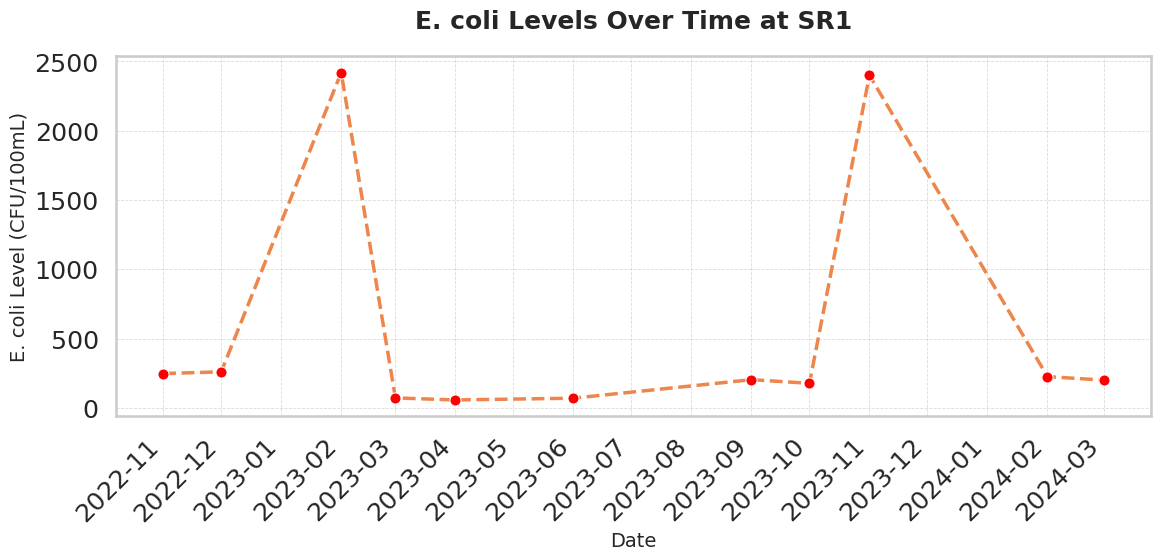

In [ ]:
# Filter the DataFrame for the given site
site = 'SR1'
filtered_df = merged[merged['SampleSite'] == site]

# Select only the 'date' and 'Ecoli (MPN/100mL)' columns
filtered_df = filtered_df[['date', 'Ecoli (MPN/100mL)']]


# Select only the 'date' and 'Ecoli (MPN/100mL)' columns
filtered_df = filtered_df[['date', 'Ecoli (MPN/100mL)']]

# Convert 'date' column to datetime
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# 1. Calculate the start and end dates
start_date = filtered_df['date'].min()
end_date = filtered_df['date'].max()
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

# 2. Convert to Month/Year format
filtered_df['YearMonth'] = filtered_df['date'].dt.to_period('M')

# 3. Average duplicate Month/Year entries
monthly_avg_df = filtered_df.groupby('YearMonth').agg({'Ecoli (MPN/100mL)': 'mean'}).reset_index()

# Convert YearMonth back to datetime for merging
monthly_avg_df['date'] = monthly_avg_df['YearMonth'].dt.to_timestamp()

# 4. Create a complete monthly date range from the start to the end of the data
full_monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

# Create a new DataFrame with the full monthly dates
full_monthly_df = pd.DataFrame(full_monthly_dates, columns=['date'])

# Merge the monthly average DataFrame with the full monthly DataFrame
merged_df = pd.merge(full_monthly_df, monthly_avg_df[['date', 'Ecoli (MPN/100mL)']], on='date', how='left')

# Check the merged DataFrame
print("Merged DataFrame with Averaged Monthly Data:")
print(merged_df)

# Set Seaborn style and context for better aesthetics
sns.set(style="whitegrid")
sns.set_context("talk", font_scale=1.1)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the data, ensuring to maintain NaN values for discontinuity
sns.lineplot(x=merged_df['date'], y=merged_df['Ecoli (MPN/100mL)'],
             marker='o', markersize=8, linewidth=2.5,
             color=sns.color_palette("muted")[1],
             markerfacecolor='red',
             linestyle='--')  # Dashed line style for a different appearance

# Add title and labels
plt.title(f'E. coli Levels Over Time at {site}', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('E. coli Level (CFU/100mL)', fontsize=14)

# Rotate x-axis labels and format them for better readability
plt.xticks(rotation=45, ha='right')

# Format x-axis ticks to show Year/Month
plt.xticks(ticks=merged_df['date'], labels=merged_df['date'].dt.strftime('%Y-%m'), rotation=45, ha='right')

# Add a grid and adjust its appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

# Add some padding to layout
plt.tight_layout()

# Show the plot
plt.show()

  SampleSite       date  Ecoli (MPN/100mL)  Rain (mm)
0        SR1 2023-09-29              204.6        5.0
1        SR1 2023-10-27              178.5       12.3
2        SR1 2023-11-14             2400.0        2.0
3        SR1 2024-02-27               66.3       10.5
4        SR1 2024-03-26              201.4        8.0
5        SR1 2024-04-10             1500.0       15.0


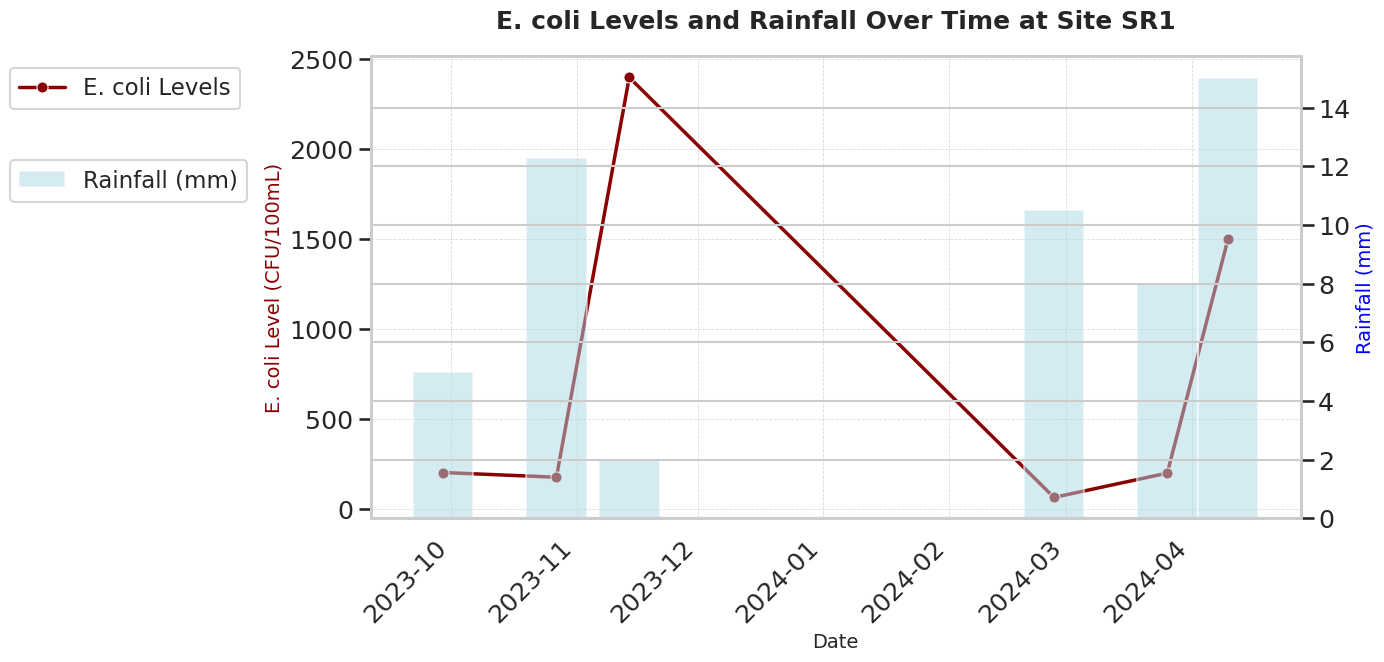

In [ ]:
# Sample E. coli data with exact matching dates
merged = pd.DataFrame({
    'SampleSite': ['SR1', 'SR1', 'SR1', 'SR1', 'SR1', 'SR1'],
    'date': ['2023-09-29', '2023-10-27', '2023-11-14', '2024-02-27', '2024-03-26', '2024-04-10'],
    'Ecoli (MPN/100mL)': [204.6, 178.5, 2400.0, 66.3, 201.4, 1500.0]
})

# Adjusted rainfall data to match E. coli sample dates
rain_data = pd.DataFrame({
    'date': ['2023-09-29', '2023-10-27', '2023-11-14', '2024-02-27', '2024-03-26', '2024-04-10'],
    'Rain (mm)': [5.0, 12.3, 2.0, 10.5, 8.0, 15.0]
})

# Convert 'date' columns to datetime
merged['date'] = pd.to_datetime(merged['date'])
rain_data['date'] = pd.to_datetime(rain_data['date'])

# Merge the DataFrames on the 'date' column
merged_df = pd.merge(merged, rain_data, on='date', how='left')

# Display the merged DataFrame to check for correctness
print(merged_df)

# Set Seaborn style and context for better aesthetics
sns.set(style="whitegrid")
sns.set_context("talk", font_scale=1.1)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot E. coli data as a line graph
sns.lineplot(x=merged_df['date'], y=merged_df['Ecoli (MPN/100mL)'],
             marker='o', markersize=8, linewidth=2.5,
             color='darkred', label='E. coli Levels', ax=ax1)

# Create a second y-axis for the rainfall
ax2 = ax1.twinx()

# Overlay the rain data as a bar graph
ax2.bar(merged_df['date'], merged_df['Rain (mm)'], width=15, alpha=0.5,
        color='lightblue', label='Rainfall (mm)', zorder=-1)

# Add title and labels
ax1.set_title(f'E. coli Levels and Rainfall Over Time at Site {site}', fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('E. coli Level (CFU/100mL)', fontsize=14, color='darkred')
ax2.set_ylabel('Rainfall (mm)', fontsize=14, color='blue')

# Set date ticks for each month
ax1.set_xticks(pd.date_range(start=merged_df['date'].min(), end=merged_df['date'].max(), freq='MS'))
ax1.set_xticklabels(pd.date_range(start=merged_df['date'].min(), end=merged_df['date'].max(), freq='MS').strftime('%Y-%m'), rotation=45, ha='right')

# Add a grid and adjust its appearance
ax1.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

# Adjust legends to be further to the side
ax1.legend(loc='upper left', bbox_to_anchor=(-.4, 1), fontsize = 'small')  # Place the E. coli legend on the left
ax2.legend(loc='upper left', bbox_to_anchor=(-.4, 0.8), fontsize = 'small')  # Place the rainfall legend on the left



# # Add some padding to layout
# plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def send_request(start_date, end_date):
  # NOAA API
  url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"

  # NOAA CDO API Token
  api_token = userdata.get('CDO_token')

  # Define parameters for the GET request
  # GHCND:USW00023213
  params = {
      "datasetid": "GHCND",               # Daily summaries dataset
      "datatypeid": "PRCP",               # Precipitation data type
      "stationid": "GHCND:USW00094728",
      "startdate": start_date.strftime('%Y-%m-%d'),
      "enddate": end_date.strftime('%Y-%m-%d'),
      "units": "standard",                # Precipitation in inches
      "limit": 1000,                      # Number of results to return (max 1000 per request)
      "format": "json"
  }

  # Headers for the GET request (include the API token)
  headers = {
      "token": api_token
  }

  # Send the GET request
  try:
    response = requests.get(url, headers=headers, params=params, timeout=1)
    print(response.text)
  except:
    # Prevents request from hanging indefinitely
    return None

  # Check if the request was successful
  if response.status_code == 200:
    try:
      rain_data = response.json()
      if 'results' in rain_data:
        results = rain_data['results']
        return pd.DataFrame(results)
      else:
        print("No results found in the response.")
        return None
    except ValueError:
      print("Failed to parse JSON response.")
      return None
    else:
      print("No results found in the response.")
      return None
  else:
    # If the request fails, print the status code and error message
    print(f"Failed to retrieve data. Status code: {response.status_code}")
    print(f"Error message: {response.text}")
    return None

print(send_request(pd.Timestamp('2024-09-24 00:00:00'), pd.Timestamp('2024-09-27 00:00:00')))

<!DOCTYPE html>
<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">
  <head>
    <script src="https://www.google-analytics.com/analytics.js"></script>
    <meta charset="utf-8" />
<script async src="https://www.googletagmanager.com/gtag/js?id=G-E1Q1BML6E5"></script>
<script>window.dataLayer = window.dataLayer || [];function gtag(){dataLayer.push(arguments)};gtag("js", new Date());gtag("set", "developer_id.dMDhkMT", true);ga("set", "hostname", "ncei.noaa.gov");gtag("config", "G-E1Q1BML6E5", {"groups":"default","page_placeholder":"PLACEHOLDER_page_location","link_attribution":true,"allow_ad_personalization_signals":false});</script>
<meta name="d

In [ ]:
cached_rain_data = pd.read_csv(rain_data_path)
cached_rain_data['date'] = pd.to_datetime(cached_rain_data['date'], format='ISO8601')
last_saved_date = cached_rain_data['date'].max()

start_date = last_saved_date
end_date = start_date
updated_rain_data = cached_rain_data # Preparing for dataset concatenation
today = pd.Timestamp.today().normalize()

while end_date != today:
  start_date = start_date + pd.Timedelta(days=1)
  end_date = start_date + pd.DateOffset(years=1)
  if end_date > today:
    end_date = today
  print(f"Fetching data for [{start_date}, {end_date}]")
  new_data = send_request(start_date, end_date)
  if new_data is None:
    print("Failed to retrieve data.")
    break
  else:
    updated_rain_data = pd.concat([updated_rain_data, new_data], axis=0)
  start_date = end_date

updated_rain_data[['date', 'datatype', 'station', 'value']].to_csv(rain_data_path, index = False)

Fetching data for [2024-09-24 00:00:00, 2024-10-02 00:00:00]
<Response [200]>
200


JSONDecodeError: Expecting value: line 1 column 1 (char 0)